In [1]:
import sys
import os
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.insert(0, _path)
print('done adding path')
    
import astropy.coordinates as coord
import numpy as np
from gala.units import UnitSystem
from yellowcard.model import TimingArgumentModel 
from yellowcard.model_select import *
from yellowcard.coordinates import fiducial_m31_c,LocalGroupHalocentric
import astropy.units as u
from scipy.optimize import minimize
from yellowcard.keplerianPlane import LGKepler
from numpy.linalg import norm
import emcee
import arviz as az
from schwimmbad import MultiPool 
import warnings
warnings.filterwarnings('ignore')
import corner

import matplotlib.pyplot as plt


done adding path


In [2]:
# modelChoice = "vdm2012-radial"
# modelChoice = "vdm2012"
# modelChoice = "fiducial2021"
# modelChoice = "apw-simulated"
modelChoice = "apw-simulated-precise"

In [3]:
model = TimingArgumentModel.from_dataset(f"../datasets/{modelChoice}.ecsv")

In [4]:
galcen_m31     = fiducial_m31_c.transform_to(model.galcen_frame)
galcen_m31_pos = galcen_m31.data.without_differentials()
galcen_m31_vel = galcen_m31.velocity
galcen_m31_L   = galcen_m31_pos.cross(galcen_m31_vel)
galcen_m31_L   = galcen_m31_L / galcen_m31_L.norm()

In [5]:
e_init   = 0.9
eta_init = 5*u.rad
alpha_init = 0*u.rad
init_par = {}

init_par['lnr'] = np.log(fiducial_m31_c.distance.value)
init_par['eParam'] = -3
init_par['coseta'] = np.cos(eta_init)
init_par['sineta'] = np.sin(eta_init)
init_par['lnM'] = np.log((4e12*u.Msun).decompose(model.unit_system).value)
# init_par['Lhatlg'] = galcen_m31_L.xyz
init_par['cosalpha'] = np.cos(alpha_init)
init_par['sinalpha'] = np.sin(alpha_init)

In [6]:
init_par['lnr']

6.594413459749778

In [7]:
init_par['lnM']

1.3862943611198904

In [8]:
model.ln_posterior(init_par)

(<Quantity -1220782.51767934>,
 [-167.26772405506136,
  57.20133852792108,
  134.09224084945131,
  727.0600850834467])

---
## creating first minimization of MCMC 

In [9]:
result = minimize( lambda *args: -model(*args)[0], model.pack_pars(init_par), method='Powell')
# result

In [10]:
result

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.17163351e-02, -2.26455366e-01,  2.51515958e-03,
        -1.99758082e-04, -2.78621208e-02,  7.35778327e-11,
        

____
# MCMC

In [11]:
nwalkers = 8*len(result.x)
sampler_x0 = np.random.normal(result.x, 1e-1, size=(nwalkers,len(result.x)))

In [12]:
with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, 
                                    ndim=len(result.x), 
                                    log_prob_fn=model, 
                                    pool=pool,
                                    blobs_dtype=model.blobs_dtype)
    state = sampler.run_mcmc(sampler_x0, 
                             nsteps=1000, 
                             progress=True)  # burn in
    sampler.reset()
    state = sampler.run_mcmc(state, 
                             nsteps=2000, 
                             progress=True)

 38%|███▊      | 379/1000 [00:48<01:20,  7.74it/s]

Step failed: Distance must be >= 0. To allow negative distance values, you must explicitly pass in a `Distance` object with the the argument 'allow_negative=True'.


100%|██████████| 2000/2000 [04:22<00:00,  7.62it/s]


----
## creating list of means of each parameter

In [13]:
everyHundo = np.vstack(sampler.chain[:, ::10])
allOfThem = np.vstack(sampler.chain[:, ::])

lil = {}
big = {}
col_names = ["lnr","eParam", "coseta", "sineta", "lnM", "cosalpha", "sinalpha"]
for i in range(len(col_names)):
    lil[col_names[i]] = everyHundo[:,i]
    big[col_names[i]] = allOfThem[:,i]
    
model_params = np.vstack([model.whats_this(big)[key] for key, values in model.whats_this(big).items()]).T

means = model.whats_this_mean(lil)
means

{'r': <Quantity 695.75953822 kpc>,
 'e': 0.9874935643579336,
 'eta': 4.301964131511811,
 'M': <Quantity 3.69605817 1e+12 solMass>,
 'alpha': 6.251176128316477}

In [15]:
big

{'lnr': array([6.51068889, 6.50799044, 6.50799044, ..., 6.58115222, 6.57341883,
        6.57341883]),
 'eParam': array([-4.41010041, -4.41145358, -4.41145358, ..., -4.50153746,
        -4.47367981, -4.47367981]),
 'coseta': array([-0.3376754 , -0.33409291, -0.33409291, ..., -0.43705494,
        -0.42549797, -0.42549797]),
 'sineta': array([-0.77719333, -0.76893756, -0.76893756, ..., -1.00455427,
        -0.97780816, -0.97780816]),
 'lnM': array([1.30417785, 1.30396393, 1.30396393, ..., 1.30280213, 1.3034028 ,
        1.3034028 ]),
 'cosalpha': array([0.77827053, 0.75625272, 0.75625272, ..., 0.92942109, 0.9698925 ,
        0.9698925 ]),
 'sinalpha': array([-0.01303469, -0.0107918 , -0.0107918 , ..., -0.01096136,
        -0.03706596, -0.03706596])}

In [16]:
np.median(model.whats_this(lil)['r'])

703.2878710018051

In [17]:
np.median(model.whats_this(lil)['M'])

3.6959979073292337

---
## figures for full sampled set of data

In [31]:
tulips = az.from_emcee(sampler,
                       var_names=["ln r","ln(1-e)", "coseta", "sineta", "ln M", "cosalpha", "sinalpha"])
lookout = az.convert_to_inference_data(model.whats_this(big))
looks = az.convert_to_dataset(lookout).to_array()

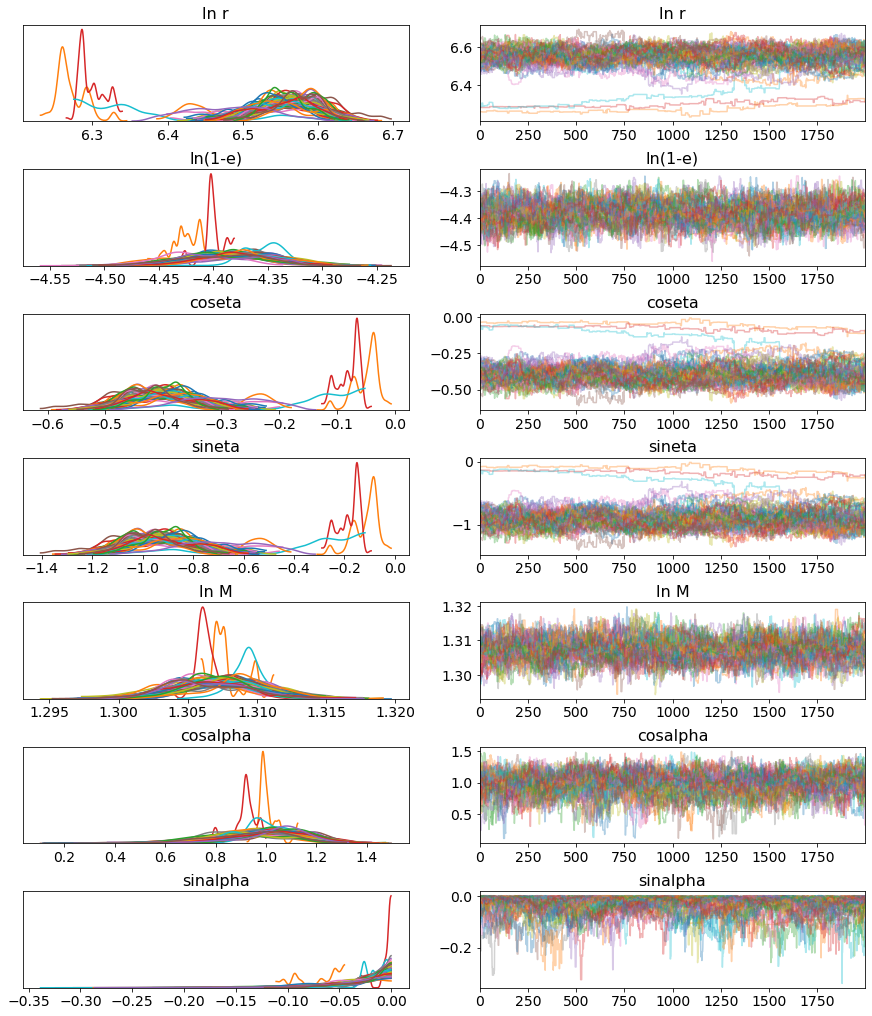

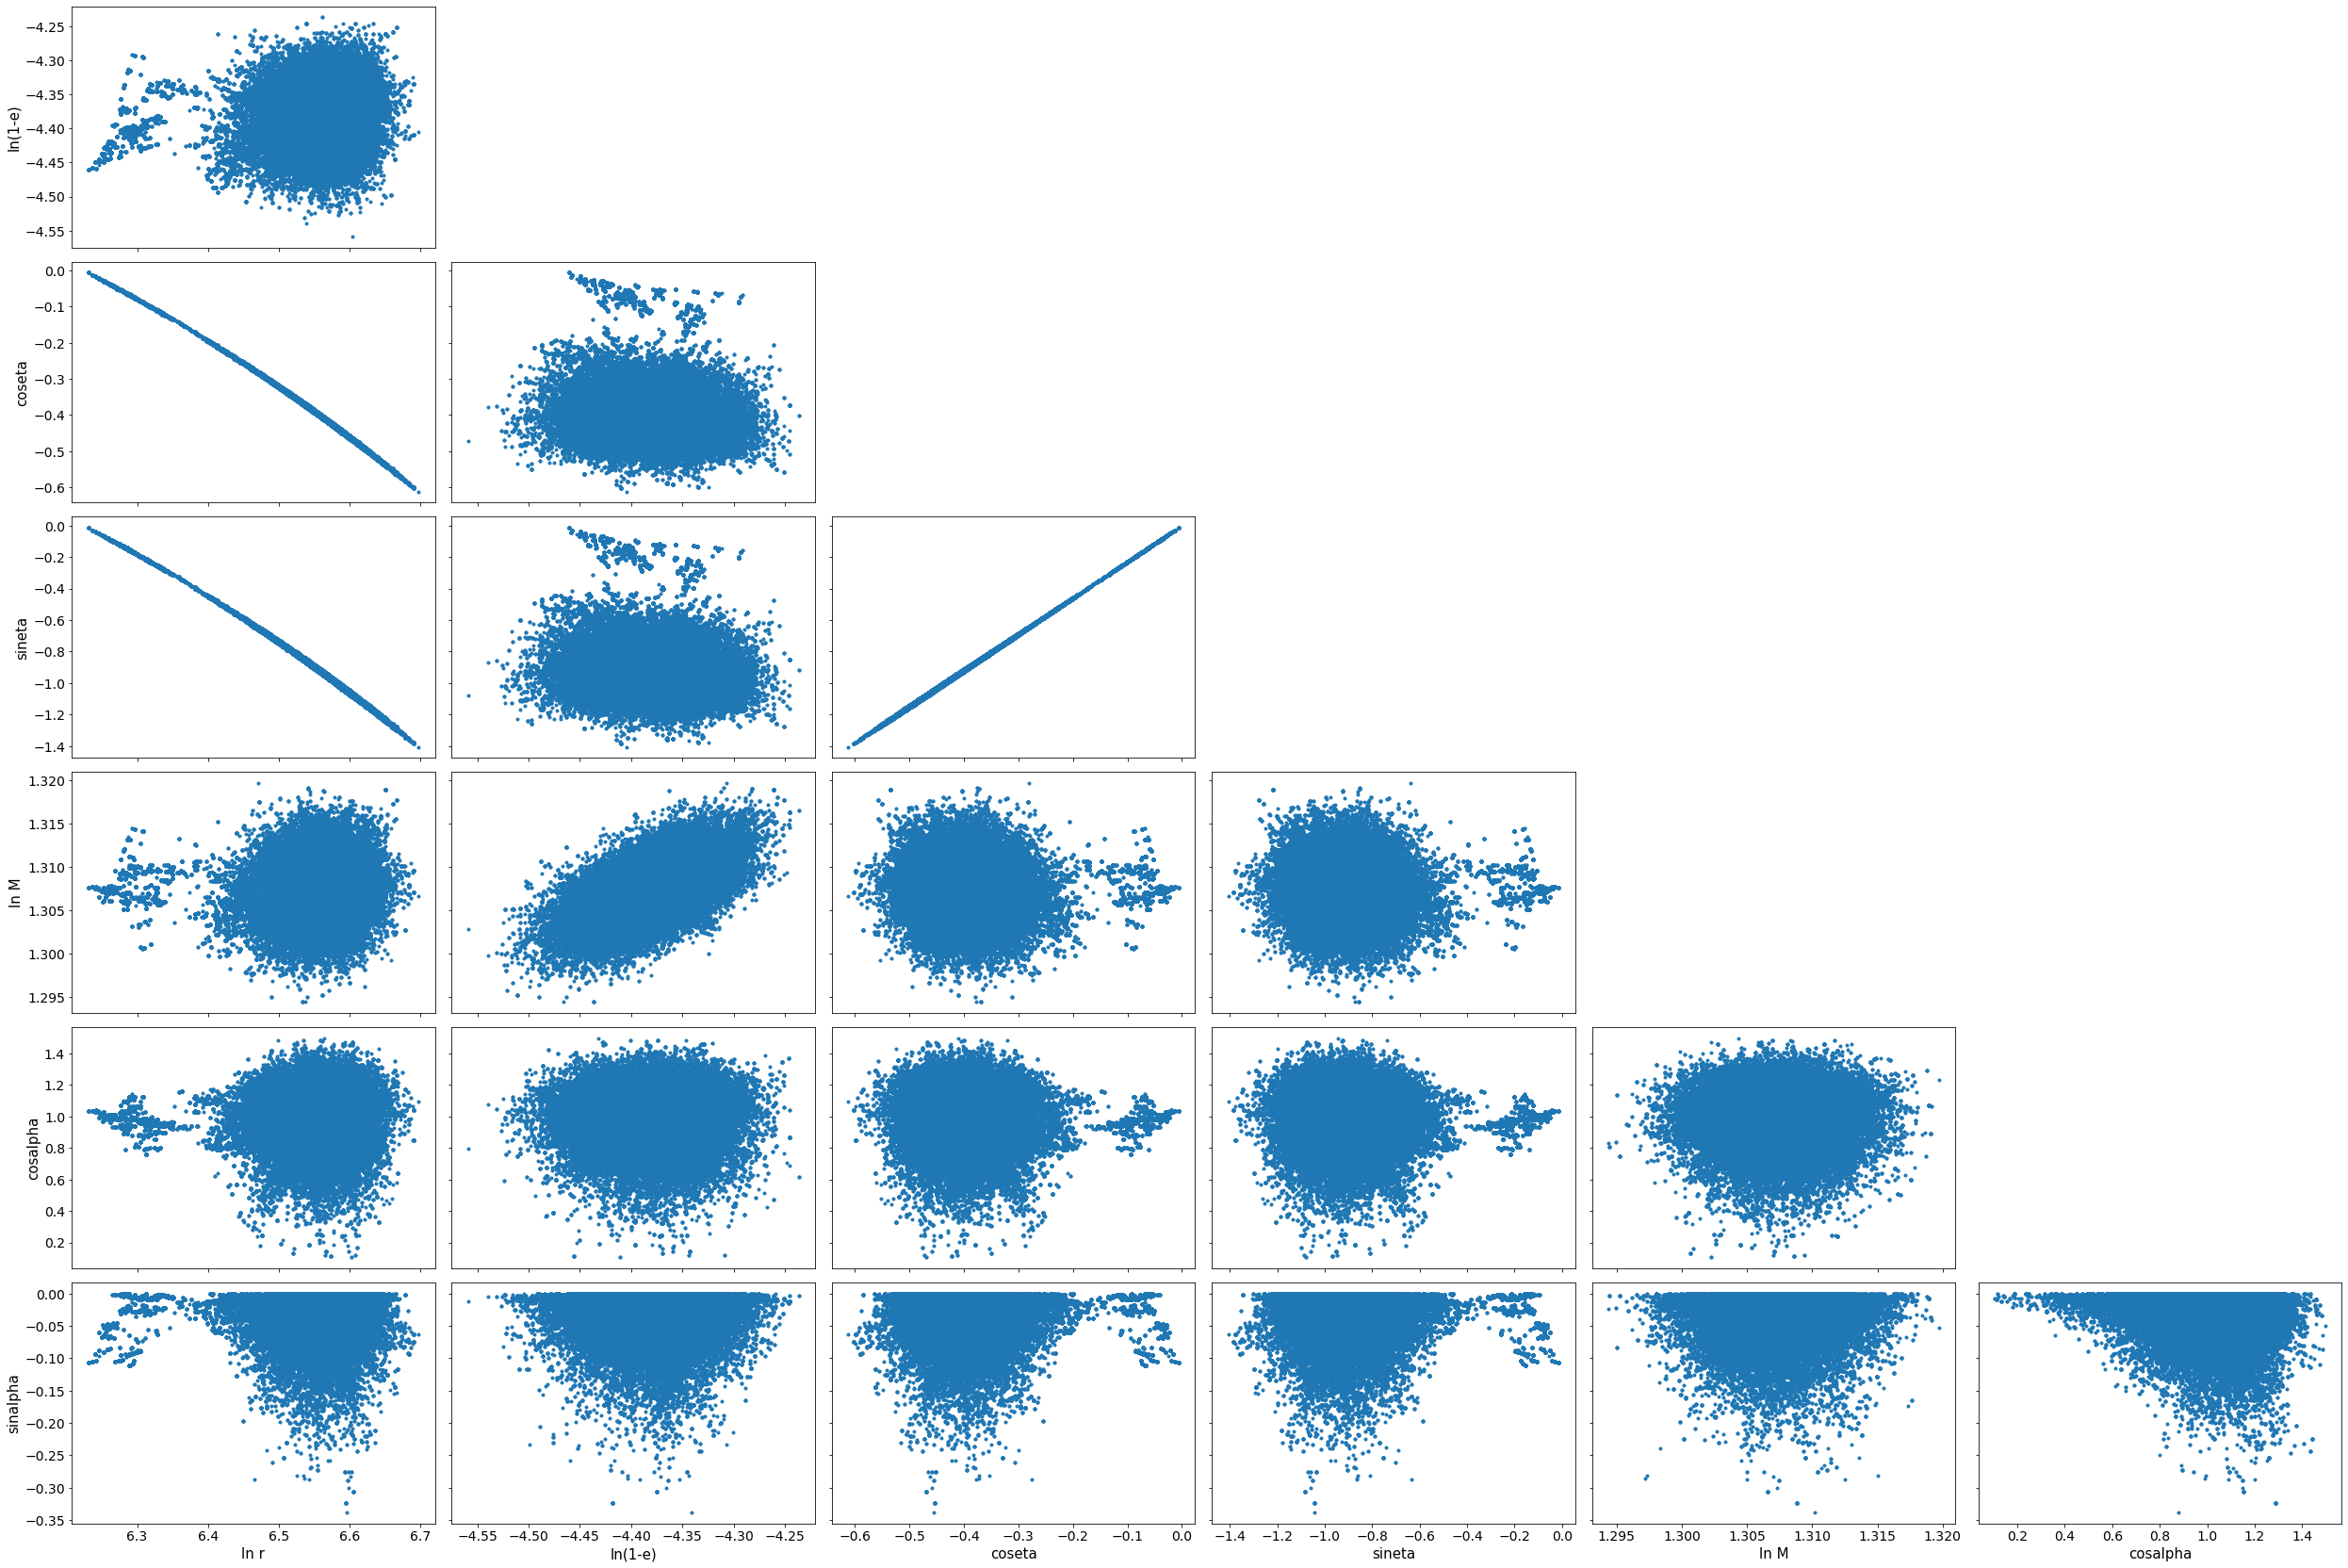

In [32]:
az.plot_trace(tulips);
az.plot_pair(tulips);

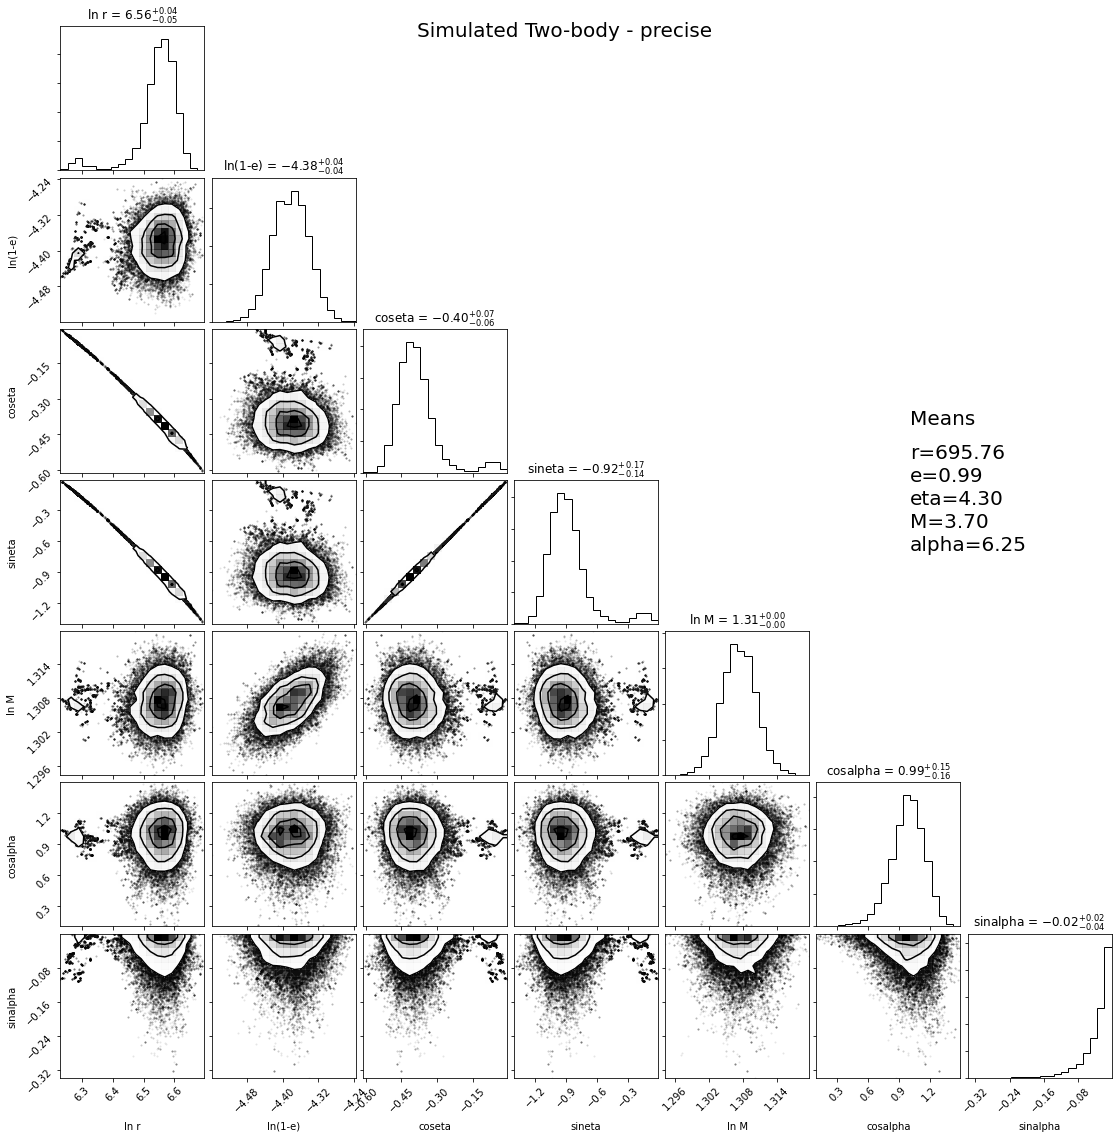

In [33]:
fig = corner.corner(np.vstack(sampler.chain[:, ::]),
                    labels=["ln r","ln(1-e)", "coseta", "sineta", "ln M", "cosalpha", "sinalpha"],
                    show_titles=True)
ii = 0
fig.text(0.8, 0.63,"Means",fontsize=20)
for key, val in means.items():
    try:
        val = val.value
    except AttributeError:
        val = val
    fig.text(0.8,0.6-0.02*ii,key+"=%.2f" % val,fontsize=20)
    ii+=1
fig.suptitle(model.title,fontsize=20)
plt.show()

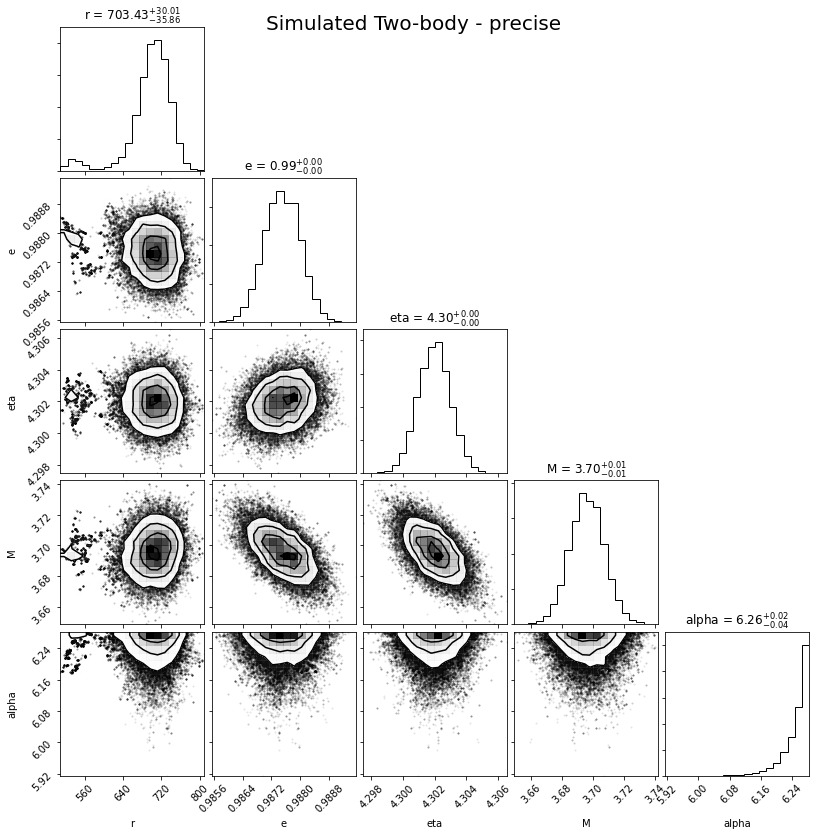

In [34]:
fig = corner.corner(model_params,
                    labels=["r","e", "eta", "M", "alpha"],
                    show_titles=True);
# ii = 0
# fig.text(0.8, 0.63,"Means",fontsize=20)
# for key, val in means.items():
#     try:
#         val = val.value
#     except AttributeError:
#         val = val
#     fig.text(0.8,0.6-0.02*ii,key+"=%.2f" % val,fontsize=20)
#     ii+=1
fig.suptitle(model.title,fontsize=20)
plt.show()

___
## the plots below are for the transformed variables

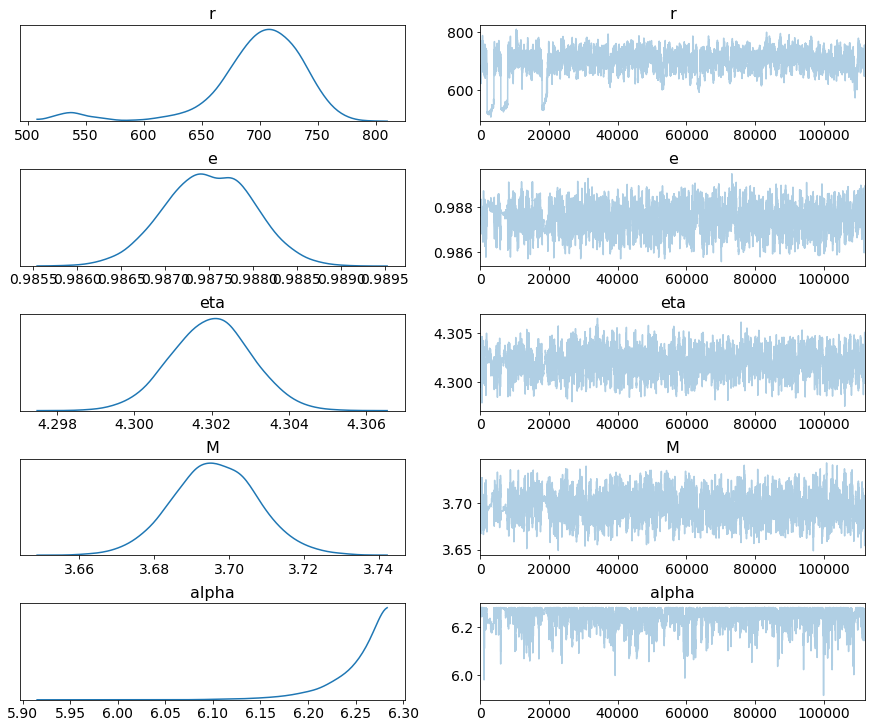

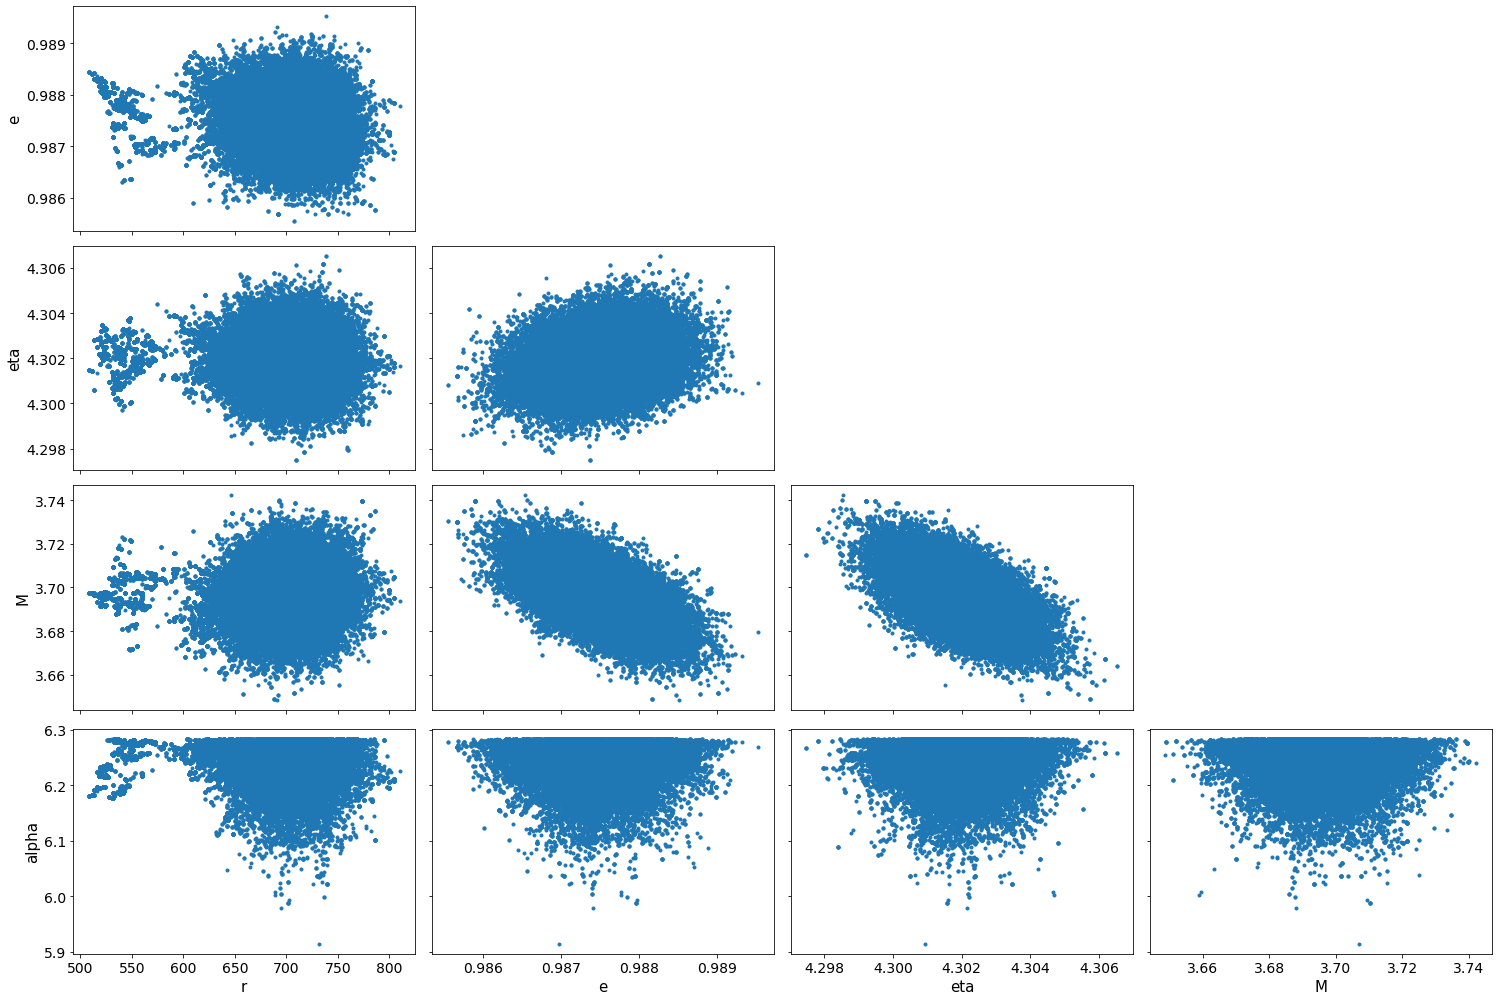

In [35]:
az.plot_trace(lookout);
az.plot_pair(lookout);

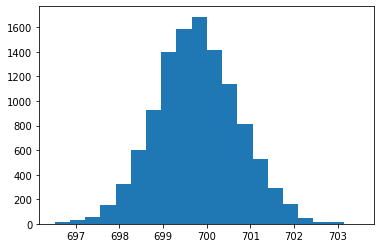

In [36]:
blobs = sampler.get_blobs()
plt.hist(np.ravel(blobs['sunToM31'][::10]),20)
plt.show()


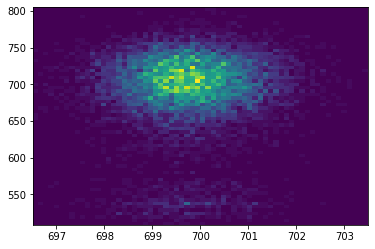

In [28]:
# plt.hist2d(np.ravel(blobs['sunToM31'][::10]), model.whats_this(lil)['r'],bins=64)
# plt.show()

----
## some extra testing stuff

In [30]:
# corner.corner(model_params,
#               labels=["r","e", "eta", "M", "alpha"],
#               show_titles=True);

In [ ]:
# meanies = np.mean(np.vstack(sampler.chain[:, ::100]), axis=0)
# whats_this_mean(model.unpack_pars(meanies))

In [ ]:
# whats_this(par_dict)

In [ ]:
# # def whats_this_mean(par_dict):
# #         ''' you can tell that i hard coded this function :) '''
# #         what_dict = {}
# #         what_dict['r'] = np.mean(np.exp(par_dict['lnr']))*u.kpc
# #         what_dict['e'] = np.mean(1 - np.exp(par_dict['eParam']))
# #         etta = np.arctan2(par_dict['sineta'],par_dict['coseta']) # *u.rad
# #         what_dict['eta'] = np.mean(etta%(2*np.pi))
# #         what_dict['M'] = np.mean(np.exp(par_dict['lnM'])*model.unit_system['mass'])
# #         allpha = np.arctan2(par_dict['sinalpha'],par_dict['cosalpha']) # *u.rad
# #         what_dict['alpha'] = np.mean(allpha%(2*np.pi))
# #         return what_dict



# def whats_this(par_dict):
#         ''' you can tell that i hard coded this function :) '''
#         what_dict = {}
#         what_dict['r'] = np.exp(par_dict['lnr'])
#         what_dict['e'] = 1 - np.exp(par_dict['eParam'])
#         etta = np.arctan2(par_dict['sineta'],par_dict['coseta']) # *u.rad
#         what_dict['eta'] = etta%(2*np.pi)
#         what_dict['M'] = np.exp(par_dict['lnM'])
#         allpha = np.arctan2(par_dict['sinalpha'],par_dict['cosalpha']) # *u.rad
#         what_dict['alpha'] = allpha%(2*np.pi)
#         return what_dict

In [ ]:
# lil

In [ ]:
# whats_this(lil)

In [ ]:
# last_pars = model.unpack_pars(sampler.chain[:, -1].T)
# last_Lhatlg = coord.CartesianRepresentation(last_pars['Lhatlg'])
# last_Lhatlg_sph = last_Lhatlg.represent_as(coord.UnitSphericalRepresentation)
# plt.scatter(last_Lhatlg_sph.lon, last_Lhatlg_sph.lat)
# plt.xlim(0, 2*np.pi)
# plt.ylim(-np.pi, np.pi)